# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [34]:
pip install tensorflow keras numpy matplotlib opencv-python pillow scikit-learn jupyter

Note: you may need to restart the kernel to use updated packages.


In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [35]:
import cv2
import imutils
from matplotlib import pyplot as plt


In [19]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

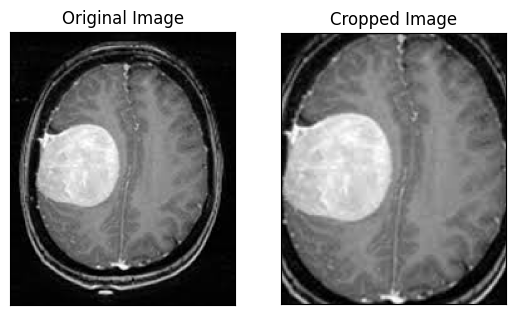

In [20]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [21]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)

            if image is None:
                print(f"Warning: Unable to read image {filepath}. Skipping.")
                continue

            try:
                image = crop_brain_contour(image, plot=False)
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.
                X.append(image)
                y.append([1] if os.path.basename(directory).lower() == 'yes' else [0])
            except Exception as e:
                print(f"Error processing image {filepath}: {e}")
                continue
                
    X = np.array(X)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [22]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1724
X shape is: (1724, 240, 240, 3)
y shape is: (1724, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [23]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

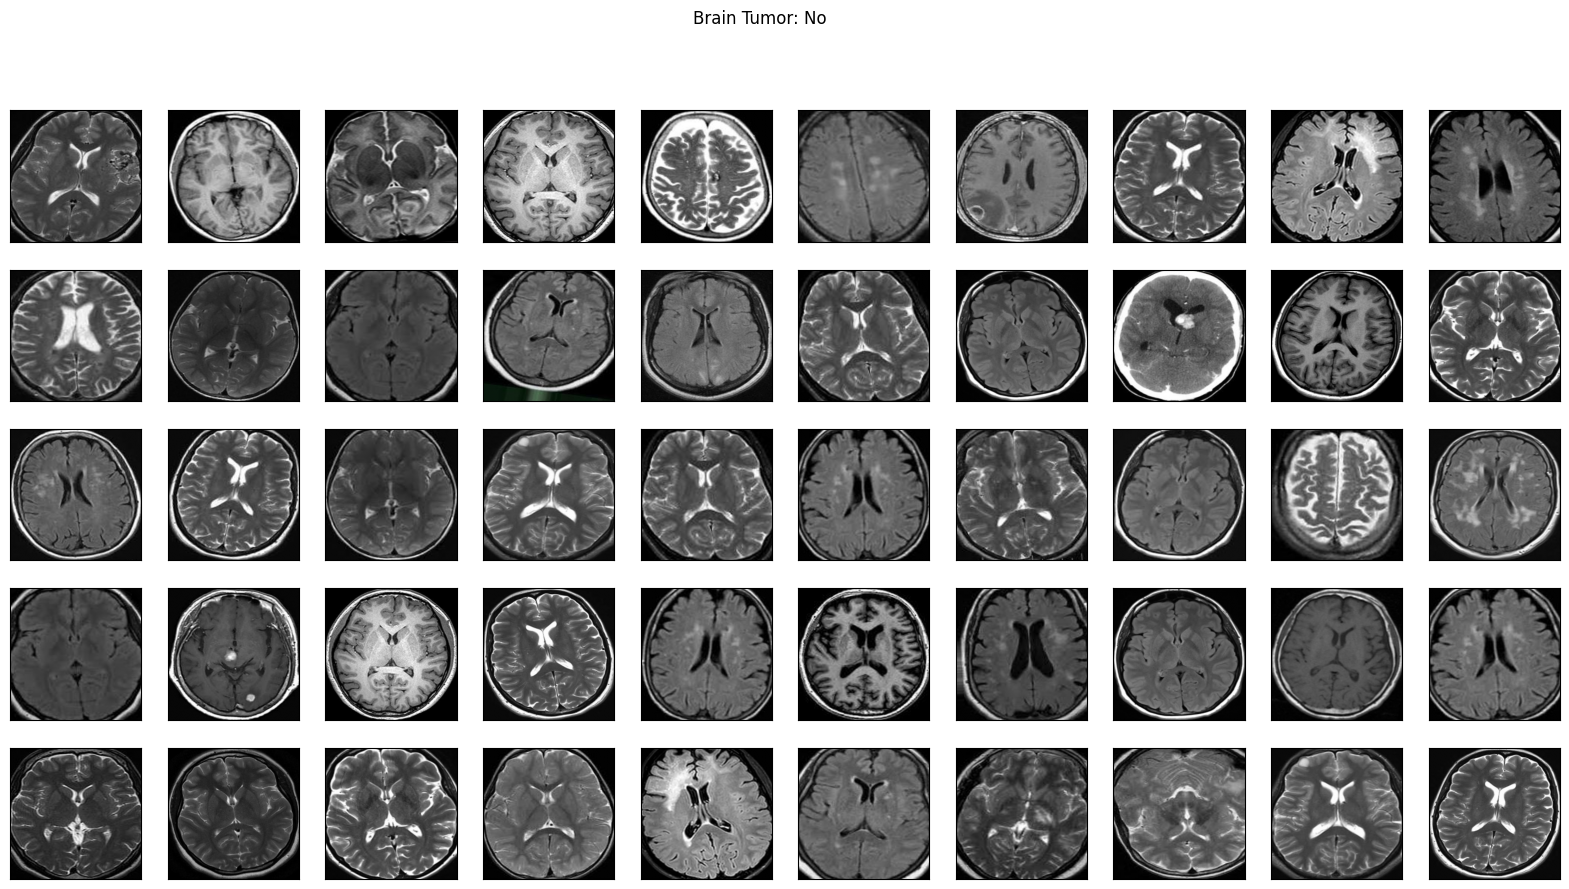

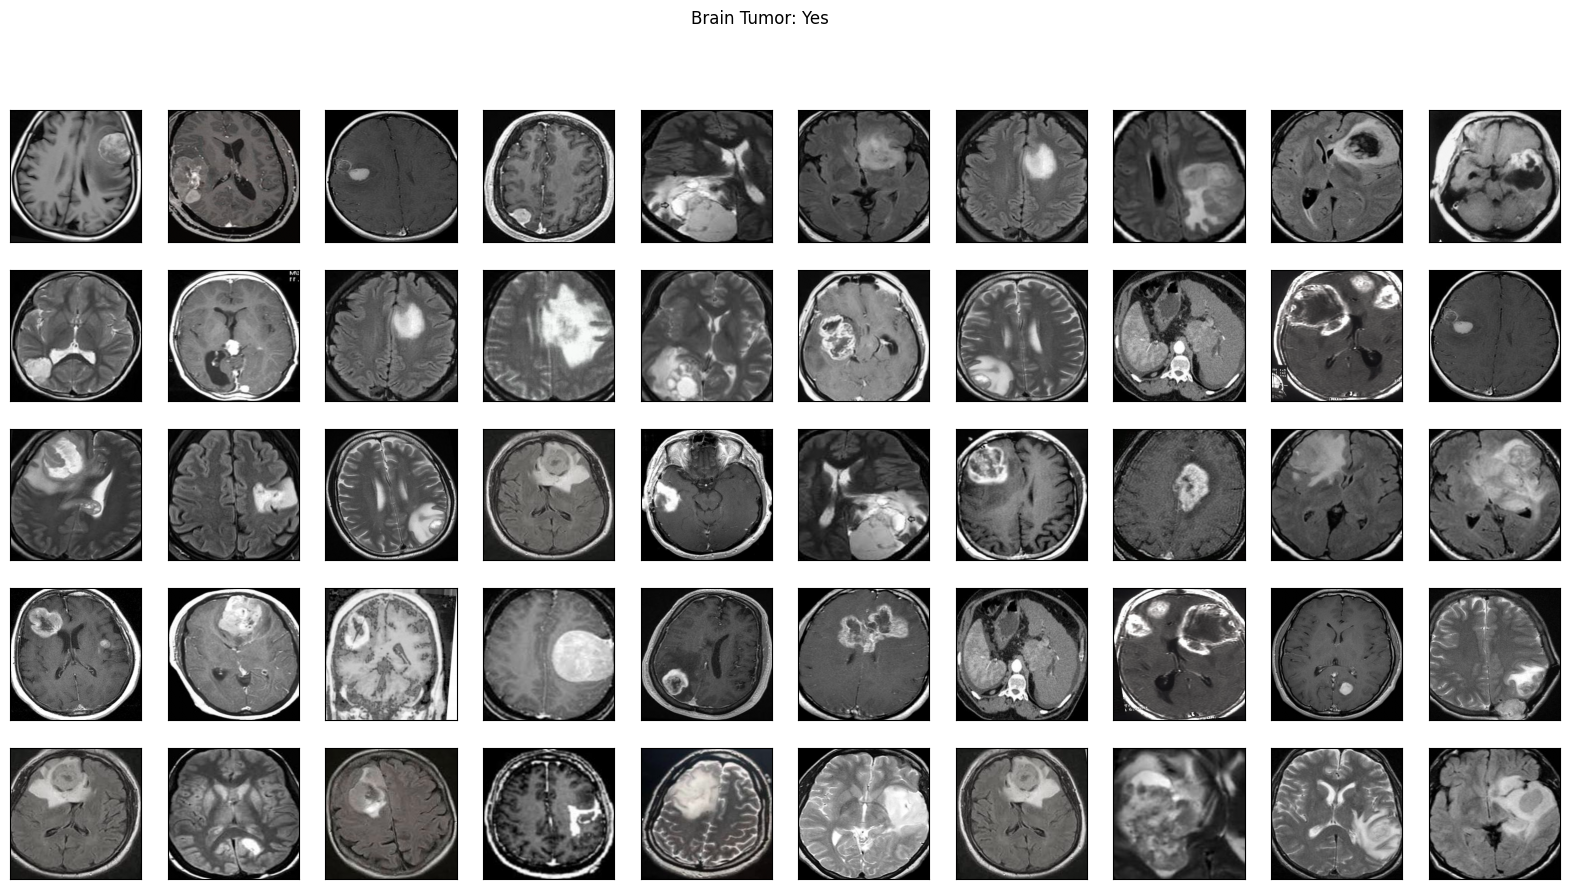

In [24]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [37]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [39]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1206
number of development examples = 259
number of test examples = 259
X_train shape: (1206, 240, 240, 3)
Y_train shape: (1206, 1)
X_val (dev) shape: (259, 240, 240, 3)
Y_val (dev) shape: (259, 1)
X_test shape: (259, 240, 240, 3)
Y_test shape: (259, 1)


Some helper functions:

In [40]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [41]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [42]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [43]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [44]:
model = build_model(IMG_SHAPE)

In [30]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [47]:
# [46]:
# unique file name that will include the epoch and the validation (development) accuracy
# CHANGE .model to .keras
filepath='cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras'

# save the model with the best validation (development) accuracy till now
# Change the ModelCheckpoint call to use the correct full filename
checkpoint = ModelCheckpoint(
    'models/{}'.format(filepath),  # Use the full filename template here
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [56]:
checkpoint = ModelCheckpoint("models/cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras", monitor='val_acc')


In [57]:
checkpoint = ModelCheckpoint(
    filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


## Train the model

In [58]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.8245 - loss: 0.4025
Epoch 1: val_accuracy improved from None to 0.76448, saving model to models/cnn-parameters-improvement-01-0.76.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 858ms/step - accuracy: 0.8217 - loss: 0.4076 - val_accuracy: 0.7645 - val_loss: 0.5659
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8390 - loss: 0.3875
Epoch 2: val_accuracy improved from 0.76448 to 0.78764, saving model to models/cnn-parameters-improvement-02-0.79.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 859ms/step - accuracy: 0.8582 - loss: 0.3471 - val_accuracy: 0.7876 - val_loss: 0.5190
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8892 - loss: 0.2683
Epoch 3: val_accuracy improved from 0.78764 to 0.84556, saving model to models/cnn-parameters-improvement-03-0.85.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 891ms/step - accuracy: 0.8980 - loss: 0.2740 - val_accuracy: 0.8456 - val_loss: 0.4640
Epoch 4/10
38/38 ━━━━━━━━━━━━━━

Let's train for a few more epochs:

In [63]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9704 - loss: 0.1220
Epoch 1: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 851ms/step - accuracy: 0.9743 - loss: 0.1093 - val_accuracy: 0.8687 - val_loss: 0.3228
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9714 - loss: 0.1128
Epoch 2: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 940ms/step - accuracy: 0.9652 - loss: 0.1149 - val_accuracy: 0.7568 - val_loss: 0.5496
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9750 - loss: 0.0985
Epoch 3: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 959ms/step - accuracy: 0.9710 - loss: 0.1112 - val_accuracy: 0.8842 - val_loss: 0.3198
Elapsed time: 0:1:45.3


In [64]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9704 - loss: 0.0982
Epoch 1: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 915ms/step - accuracy: 0.9627 - loss: 0.1152 - val_accuracy: 0.8417 - val_loss: 0.3993
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.9731 - loss: 0.0957
Epoch 2: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 902ms/step - accuracy: 0.9668 - loss: 0.1108 - val_accuracy: 0.8726 - val_loss: 0.3537
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9751 - loss: 0.0823
Epoch 3: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 953ms/step - accuracy: 0.9710 - loss: 0.0943 - val_accuracy: 0.8958 - val_loss: 0.3239
Elapsed time: 0:1:46.1


In [65]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.9737 - loss: 0.0868
Epoch 1: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 872ms/step - accuracy: 0.9718 - loss: 0.0960 - val_accuracy: 0.8803 - val_loss: 0.3603
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9763 - loss: 0.0877
Epoch 2: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 925ms/step - accuracy: 0.9726 - loss: 0.0954 - val_accuracy: 0.8649 - val_loss: 0.3751
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9857 - loss: 0.0578
Epoch 3: val_accuracy did not improve from 0.89575
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 909ms/step - accuracy: 0.9851 - loss: 0.0638 - val_accuracy: 0.8571 - val_loss: 0.3825
Elapsed time: 0:1:43.7


In [66]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.9839 - loss: 0.0605
Epoch 1: val_accuracy improved from 0.89575 to 0.91506, saving model to models/cnn-parameters-improvement-01-0.92.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 942ms/step - accuracy: 0.9859 - loss: 0.0566 - val_accuracy: 0.9151 - val_loss: 0.2737
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.9935 - loss: 0.0502
Epoch 2: val_accuracy did not improve from 0.91506
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 939ms/step - accuracy: 0.9934 - loss: 0.0493 - val_accuracy: 0.8263 - val_loss: 0.4979
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9906 - loss: 0.0582
Epoch 3: val_accuracy did not improve from 0.91506
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 918ms/step - accuracy: 0.9909 - loss: 0.0553 - val_accuracy: 0.9073 - val_loss: 0.2649
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9912 - loss: 0.0602
Epoch 4: val_accuracy did not improve from 0.91506
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 90

In [67]:
history = model.history.history

In [68]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [73]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

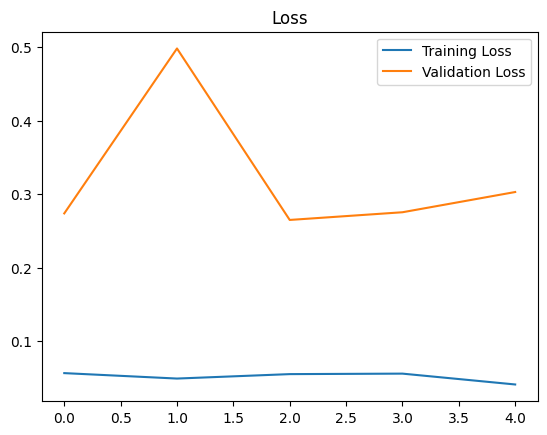

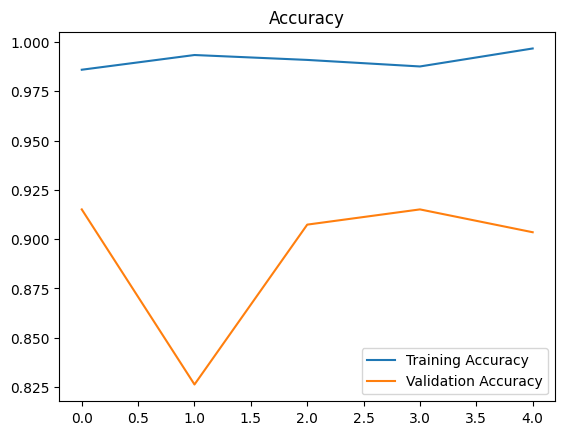

In [74]:
plot_metrics(history)

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [97]:
model = load_model('models\cnn-parameters-improvement-01-0.76.keras')

In [98]:
# Assuming you are in the *old* environment with the correct Keras/TF version

# 1. Load the model in the old environment
old_model = tf.keras.models.load_model('models\cnn-parameters-improvement-01-0.76.keras')

# 2. Save it in the new Keras V3 format
old_model.save('best_model.keras') 

best_model = load_model(filepath='best_model.keras')

In [99]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [100]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7606 - loss: 0.5644


### Accuracy of the best model on the testing data:

In [101]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.5644127130508423
Test Accuracy = 0.760617733001709


### F1 score for the best model on the testing data:

In [102]:
y_test_prob = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


In [104]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.802547770700637


Let's also find the f1 score on the validation data:

In [83]:
y_val_prob = best_model.predict(X_val)

In [85]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9123867069486403


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [105]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [106]:
# the whole data
data_percentage(y)

Number of examples: 1724
Percentage of positive examples: 51.39211136890951%, number of pos examples: 886
Percentage of negative examples: 48.60788863109049%, number of neg examples: 838


In [107]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1206
Percentage of positive examples: 51.243781094527364%, number of pos examples: 618
Percentage of negative examples: 48.756218905472636%, number of neg examples: 588
Validation Data:
Number of examples: 259
Percentage of positive examples: 49.80694980694981%, number of pos examples: 129
Percentage of negative examples: 50.19305019305019%, number of neg examples: 130
Testing Data:
Number of examples: 259
Percentage of positive examples: 53.66795366795367%, number of pos examples: 139
Percentage of negative examples: 46.33204633204633%, number of neg examples: 120


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!